# Using Callbacks

Callbacks are an integral part of Keras. Callbacks are used to get performance information, log progress, halt in the event of errors, tune parameters, save model state (in case of crash, etc.), finish training once loss is minimized. The list goes on.
Callbacks can be passed to fit, evaluate and predict methods of keras.Model. 

## Goals

The overarching goal is to learn to use callbacks for some typical tasks. These include:
- Reporting about training progress.
- Stoping once training no longer reduces loss.
- Tuning hyperparameters.
- Implementing adaptive learning rate decay.
- Finding an optimal batch-size for training.
- Putting some of this into ```my_keras_utils.py``` so that they can be easily called and reused.

## What's Here?

I continue working with MNIST data, which I began working with in [my first Keras models](first_model.ipynb). 

My **concrete objective** is to tune a model that does well on Kaggle: 97th percentile? That's tough, but I think I can make it work.

In [1]:
import numpy as np
from datetime import datetime, time, timedelta

import pandas as pd
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers

import my_keras_utils as my_utils

In [2]:
## Load our data.
## Since the load process is a little slow, the try-except allows us to re-run all 
## cells without having to wait. 
try:
    ## Raises NameError and loads data if X_train is not defined.
    X_train.shape
except NameError: 
    ((X_train, y_train), (X_dev, y_dev), (X_test, y_test)) = my_utils.load_kaggle_mnist()
X_train.shape




(38000, 784)

In [3]:
## Let's use the dropout model from my first_model notebook.

inputs = keras.Input(shape=(784))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Dropout(rate = .05)(x)
x = layers.Dense(100, activation='relu',)(x)
x = layers.Dropout(rate = .15)(x)
x = layers.Dense(100, activation='relu',)(x)
x = layers.Dropout(rate = .15)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_dropout = keras.Model(inputs=inputs, outputs=outputs, name='Dropout')
model_dropout.summary()
optimizer = keras.optimizers.Adam(.001)

model_dropout.compile(optimizer=optimizer, 
                loss="sparse_categorical_crossentropy",
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
            )
init_weights = model_dropout.get_weights()


Model: "Dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
rescaling (Rescaling)        (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0   

In [28]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience = 10, 
                                                restore_best_weights = True)
progress_update = my_utils.TimedProgressUpdate(1)
callbacks = [progress_update, early_stopping]
epochs = 0
initial_epoch = 0
batch_size = 128

In [5]:
if False: ## reinitialize
    model_dropout.set_weights(init_weights)    
increment_epochs = 5
epochs += increment_epochs

history = model_dropout.fit(X_train, y_train, 
                        epochs=epochs,
                        initial_epoch = initial_epoch,
                        batch_size=batch_size, 
                        validation_data=(X_dev, y_dev),
                        callbacks = callbacks,
                        verbose = 1)
initial_epoch += increment_epochs

Begin training of Dropout at 10:00:12. Progress updates every 6.0 seconds.
Epoch 1/5
297/297 [==============================] - 2s 6ms/step - loss: 0.5172 - acc: 0.8454 - val_loss: 0.2350 - val_acc: 0.9335
Epoch 2/5
297/297 [==============================] - 1s 5ms/step - loss: 0.2340 - acc: 0.9295 - val_loss: 0.1648 - val_acc: 0.9540
Epoch 3/5
297/297 [==============================] - 1s 5ms/step - loss: 0.1704 - acc: 0.9475 - val_loss: 0.1391 - val_acc: 0.9590
Epoch 4/5
297/297 [==============================] - 1s 5ms/step - loss: 0.1426 - acc: 0.9568 - val_loss: 0.1271 - val_acc: 0.9650
Epoch 5/5
297/297 [==============================] - 1s 5ms/step - loss: 0.1216 - acc: 0.9623 - val_loss: 0.1119 - val_acc: 0.9680
Finished fitting at 10:00:20. Elapsed time 0:00:08.143795.


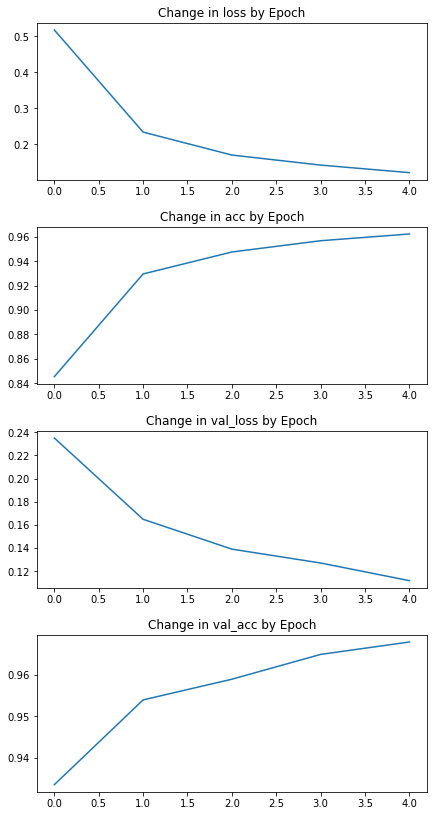

In [6]:
my_utils.history_plot(history, start_epoch=0, end_epoch=None)


#### Read the Docs

Reading the documentation was really helpful. Note that the search function _will_ use callbacks. So, instead of worrying about 
the ```max_epochs```, you can (if you have the resources and time--which _is_ a resource) just add a realistic ```EarlyStopping``` callback. Below, I use this to stop if training loss is not decreasing.

In [7]:
def model_builder(hp):
    ## Define the parameter search space.

    hp_dropout_x1 = hp.Float('rate1', min_value = .05, max_value = .5, step=.01)
    hp_dropout_w1 = hp.Float('rate2', min_value = .05, max_value = .5, step=.01)
    hp_dropout_w2 = hp.Float('rate3', min_value = .05, max_value = .5, step=.01)

    ## ### I need to learn about the options here. 'Choice' means "here are your choices"
    ## ### 'Int' is a different option that searches an integer range by steps.

    inputs = keras.Input(shape=(784))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.Dropout(rate = hp_dropout_x1)(x)
    x = layers.Dense(100, activation='relu',)(x)
    x = layers.Dropout(rate = hp_dropout_w1)(x)
    x = layers.Dense(100, activation='relu',)(x)
    x = layers.Dropout(rate = hp_dropout_w2)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer = keras.optimizers.Adam(.001),
                    loss = "sparse_categorical_crossentropy",
                    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )

    return model

	


In [10]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 200,
                     hyperband_iterations = 10,
                     factor = 3,
                     directory = 'ignored/kt_trials',
                     project_name = 'dropout_mnist')	

tuner.search_space_summary()

In [8]:
## prevent bloated ipython output during training.
clear_output = my_utils.ClearTrainingOutput()
timed_update = my_utils.TimedProgressUpdate()
## stop when training loss is not happening.
train_loss_stopping = keras.callbacks.EarlyStopping(monitor='loss', 
                                                patience = 10, 
                                                restore_best_weights = False
                                                )

tuner_callbacks = [clear_output, train_loss_stopping]


In [20]:
start = datetime.now()
tuner.search(X_train, y_train, 
            epochs=50,
            batch_size=128, 
            validation_data=(X_dev, y_dev),
            callbacks = tuner_callbacks,
            )


INFO:tensorflow:Oracle triggered exit


In [21]:
end = datetime.now()
print(end - start)
tuner.results_summary()

0:04:21.113614


## Ran the Hyperband, 

with the following params:
```
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 200,
                     hyperband_iterations = 10,
                     factor = 3,
                     directory = 'ignored/kt_trials',
                     project_name = 'dropout_mnist')	
###
tuner.search(X_train, y_train, 
            epochs=50,
            batch_size=128, 
            validation_data=(X_dev, y_dev),
            callbacks = tuner_callbacks,
            )
```
Which involved way too many iterations. I didn't notice the hyperband_iterations param (10!).

### os.path.normpath

Per [Issue #198](https://github.com/keras-team/keras-tuner/issues/198) you may need to add os.path.normpath() to the directory keyword arg in Windows and the path to the logs needs to be short. (E.g., you won't be able to use my_trials/this_type_of_trial/this_trial--too long. Try mt/t/this).

In [9]:
def rand_search_model_builder(hp):
    ## Define the hyperparameter search space.

    hp_dropout_x1 = hp.Float('rate1', min_value = .05, max_value = .5, step=.01)
    hp_dropout_w1 = hp.Float('rate2', min_value = .05, max_value = .5, step=.01)
    hp_dropout_w2 = hp.Float('rate3', min_value = .05, max_value = .5, step=.01)

    # Define the hypermodel
    inputs = keras.Input(shape=(784))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.Dropout(rate = hp_dropout_x1)(x)
    x = layers.Dense(100, activation='relu',)(x)
    x = layers.Dropout(rate = hp_dropout_w1)(x)
    x = layers.Dense(100, activation='relu',)(x)
    x = layers.Dropout(rate = hp_dropout_w2)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer = keras.optimizers.Adam(.001),
                    loss = "sparse_categorical_crossentropy",
                    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )

    return model

In [18]:
#kt.tuners.RandomSearch?
new_tuner = kt.tuners.RandomSearch(rand_search_model_builder,
                     objective = 'val_loss', 
                     max_trials = 100,
                     executions_per_trial=2,
                     directory = os.path.normpath('ignored/mnist'),
                     project_name = 'rs')
new_tuner.search_space_summary()                    

Search space summary
Default search space size: 3
rate1 (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': 0.01, 'sampling': None}
rate2 (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': 0.01, 'sampling': None}
rate3 (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': 0.01, 'sampling': None}


In [20]:

new_tuner.search(X_train, y_train, 
            epochs=50,
            batch_size=128, 
            validation_data=(X_dev, y_dev),
            callbacks = tuner_callbacks,
            verbose = 0
            )

INFO:tensorflow:Oracle triggered exit


In [21]:
new_tuner.results_summary()

Results summary
Results in ignored\mnist\rs
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
rate1: 0.34
rate2: 0.18000000000000005
rate3: 0.19
Score: 0.07145744562149048
Trial summary
Hyperparameters:
rate1: 0.4800000000000001
rate2: 0.16000000000000003
rate3: 0.07
Score: 0.07464877143502235
Trial summary
Hyperparameters:
rate1: 0.27
rate2: 0.30000000000000004
rate3: 0.2
Score: 0.07504328340291977
Trial summary
Hyperparameters:
rate1: 0.37000000000000005
rate2: 0.09000000000000001
rate3: 0.18000000000000005
Score: 0.07584869116544724
Trial summary
Hyperparameters:
rate1: 0.22000000000000003
rate2: 0.16000000000000003
rate3: 0.07
Score: 0.0758586935698986
Trial summary
Hyperparameters:
rate1: 0.32000000000000006
rate2: 0.2
rate3: 0.29000000000000004
Score: 0.07601206004619598
Trial summary
Hyperparameters:
rate1: 0.29000000000000004
rate2: 0.31000000000000005
rate3: 0.060000000000000005
Score: 0.07668517157435417
Trial summary
Hyperparam

In [41]:
best = new_tuner.get_best_models(3)
best

In [42]:
initial_epoch = 60


In [43]:
#keras.callbacks.ReduceLROnPlateau?
adaptive_lr = keras.callbacks.ReduceLROnPlateau(
                    monitor='loss', 
                    factor=0.5,)

callbacks = [adaptive_lr, progress_update]

Init signature:
keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
    **kwargs,
)
Docstring:     
Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor
of 2-10 once learning stagnates. This callback monitors a
quantity and if no improvement is seen for a 'patience' number
of epochs, the learning rate is reduced.

Example:

```python
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
model.fit(X_train, Y_train, callbacks=[reduce_lr])
```

Arguments:
    monitor: quantity to be monitored.
    factor: factor by which the learning rate will be reduced.
      `new_lr = lr * factor`.
    patience: number of epochs with no improvement after which learning rate
      will be reduced.
    verbose: int. 0: quiet, 1: update messages.
    

In [44]:
histories = []
epochs = 50 + initial_epoch
histories.append(best[0].fit(X_train, y_train, 
                    epochs=epochs,
                    initial_epoch = initial_epoch,
                    batch_size=128, 
                    validation_data=(X_dev, y_dev),
                    callbacks = callbacks,
                    verbose = 0))

histories.append(best[1].fit(X_train, y_train, 
                        epochs=epochs,
                        initial_epoch = initial_epoch,
                        batch_size=128, 
                        validation_data=(X_dev, y_dev),
                        callbacks = callbacks,
                        verbose = 0))

histories.append(best[1].fit(X_train, y_train, 
                        epochs=epochs,
                        initial_epoch = initial_epoch,
                        batch_size=128, 
                        validation_data=(X_dev, y_dev),
                        callbacks = callbacks,
                        verbose = 0))
initial_epoch += epochs

Begin training of functional_1 at 16:40:28. Progress updates every 60.0 seconds.
Finished fitting at 16:41:27. Elapsed time 0:00:58.904488.
Begin training of functional_1 at 16:41:27. Progress updates every 60.0 seconds.
Finished fitting at 16:42:24. Elapsed time 0:00:56.971290.
Begin training of functional_1 at 16:42:24. Progress updates every 60.0 seconds.
Finished fitting at 16:43:20. Elapsed time 0:00:55.870633.


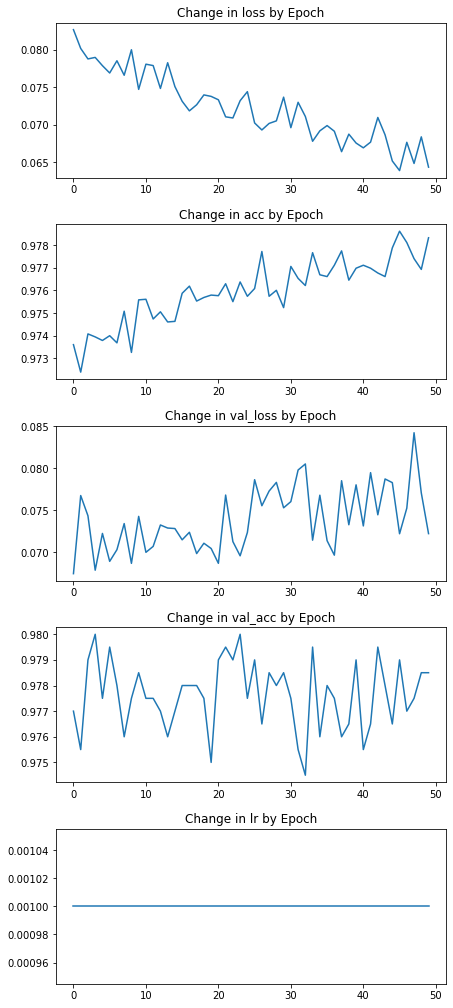

In [45]:
my_utils.history_plot(histories[0])

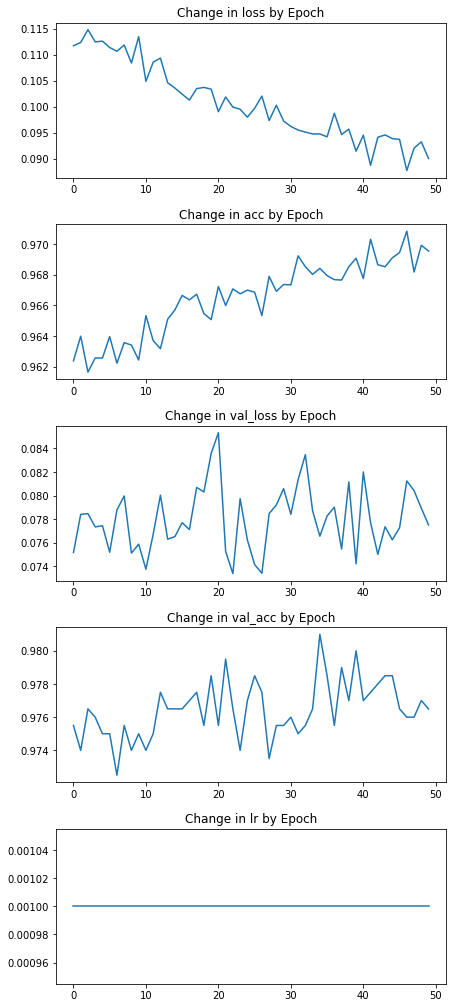

In [46]:
my_utils.history_plot(histories[1])

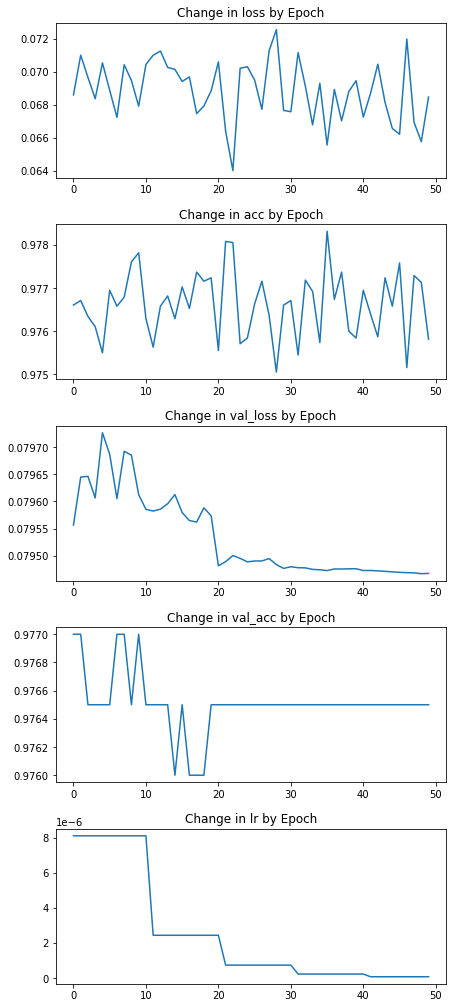

In [38]:
my_utils.history_plot(histories[2])